In [7]:
import requests
import pandas as pd
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# URL do novo arquivo no GitHub
url = "https://raw.githubusercontent.com/adirsonmfjr/credito-rural/main/Dados_Estoque_credito_rural_Comercializacao_1993-2023.xls"

# Baixar o arquivo
response = requests.get(url)

if response.status_code == 200:
    # Carregar o Excel com ajustes
    df = pd.read_excel(
        BytesIO(response.content),
        sheet_name="S√©ries",  # Nome da aba no Excel
        engine="xlrd",
        dtype=str  # L√™ como string para evitar convers√µes erradas
    )

    # Converter colunas num√©ricas para float e substituir NaN por 0
    for col in df.columns[3:]:  # Pular as tr√™s primeiras colunas (Sigla, C√≥digo, Munic√≠pio)
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    print("Arquivo carregado com sucesso!")

else:
    print("Erro ao baixar o arquivo:", response.status_code)

# Configurar pandas para exibir valores sem nota√ß√£o cient√≠fica
pd.set_option('display.float_format', '{:,.0f}'.format)

# Exibir as primeiras linhas para verificar se faz sentido
df.head()


Arquivo carregado com sucesso!


Sigla   Codigo     Munic√≠pio  1993  1994  1995  1996  1997  1998  1999  ...  \
0    AC  1200013    Acrel√¢ndia     0     0     0     0     0     0     0  ...   
1    AC  1200054  Assis Brasil     0     0     0     0     0     0     0  ...   
2    AC  1200104     Brasil√©ia     0     0     0     0     0     0     0  ...   
3    AC  1200138        Bujari     0     0     0     0     0     0     0  ...   
4    AC  1200179      Capixaba     0     0     0     0     0     0     0  ...   

   2014     2015     2016  2017  2018  2019  2020  2021  2022  2023  
0     0        0        0     0     0     0     0     0     0     0  
1     0        0        0     0     0     0     0     0     0     0  
2     0  1851638  1712837     0     0     0     0     0     0     0  
3     0        0        0     0     0     0     0     0     0     0  
4     0        0        0     0     0     0     0     0     0     0  

[5 rows x 34 columns]

In [8]:
# Identificar as colunas de anos (ignorar as colunas categ√≥ricas)
colunas_anos = [col for col in df.columns if col.isdigit()]  # Filtra apenas colunas com nome num√©rico

# Criar colunas de Data Inicial e Data Final
df["Data_Inicial"] = int(min(colunas_anos))  # Primeiro ano dispon√≠vel na base
df["Data_Final"] = int(max(colunas_anos))    # √öltimo ano dispon√≠vel na base

# Criar a coluna de Rec√™ncia (R)
def calcular_recencia(row):
    anos_validos = [int(ano) for ano in colunas_anos if row[ano] > 0]  # Filtra os anos com estoque maior que 0

    if anos_validos:
        return df["Data_Final"].iloc[0] - max(anos_validos)  # √öltimo ano de estoque - Data Final
    return df["Data_Final"].iloc[0] - df["Data_Inicial"].iloc[0]  # Caso n√£o tenha estoque, pega o per√≠odo total

df["Recencia"] = df.apply(calcular_recencia, axis=1)

# Criar a coluna de Frequ√™ncia (F) - Contagem de anos com estoque positivo
df["Frequencia"] = (df[colunas_anos] > 0).sum(axis=1)

# Criar a coluna Monet√°rio (M) - Soma total dos estoques ao longo do per√≠odo
df["Monetario"] = df[colunas_anos].sum(axis=1)

# Exibir os dados processados para verificar se est√° condizente
df.head()


Sigla   Codigo     Munic√≠pio  1993  1994  1995  1996  1997  1998  1999  ...  \
0    AC  1200013    Acrel√¢ndia     0     0     0     0     0     0     0  ...   
1    AC  1200054  Assis Brasil     0     0     0     0     0     0     0  ...   
2    AC  1200104     Brasil√©ia     0     0     0     0     0     0     0  ...   
3    AC  1200138        Bujari     0     0     0     0     0     0     0  ...   
4    AC  1200179      Capixaba     0     0     0     0     0     0     0  ...   

   2019  2020  2021  2022  2023  Data_Inicial  Data_Final  Recencia  \
0     0     0     0     0     0          1993        2023        10   
1     0     0     0     0     0          1993        2023        18   
2     0     0     0     0     0          1993        2023         7   
3     0     0     0     0     0          1993        2023        30   
4     0     0     0     0     0          1993        2023        30   

   Frequencia  Monetario  
0           1      67543  
1           2   15317140  
2           2    3564475  
3           0          0  
4           0          0  

[5 rows x 39 columns]

In [9]:
# Criar uma c√≥pia do dataframe para os c√°lculos LFM, ajustando a rec√™ncia para refletir melhor a varia√ß√£o do cr√©dito em diferentes per√≠odos e permitir uma melhor compara√ß√£o.
rfm = df.copy()

# Criar a coluna de Longevidade (L) como o intervalo entre o primeiro e o √∫ltimo ano com cr√©dito
def calcular_longevidade(row):
    anos_validos = [int(ano) for ano in colunas_anos if row[ano] > 0]  # Anos em que o munic√≠pio pegou cr√©dito

    if anos_validos:
        return max(anos_validos) - min(anos_validos)  # √öltimo ano - Primeiro ano
    return 0  # Caso nunca tenha pego cr√©dito

rfm["Longevidade"] = rfm.apply(calcular_longevidade, axis=1)

# Criar scores LFM por quintis (de 1 a 5)
rfm["score_L"] = pd.qcut(rfm["Longevidade"], 5, labels=False, duplicates="drop") + 1
rfm["score_R"] = pd.qcut(-rfm["Recencia"], 5, labels=False, duplicates="drop") + 1  # Mantendo score_R original
rfm["score_F"] = pd.qcut(rfm["Frequencia"], 5, labels=False, duplicates="drop") + 1
rfm["score_M"] = pd.qcut(rfm["Monetario"], 5, labels=False, duplicates="drop") + 1

# Criar um score m√©dio entre Frequ√™ncia e Monet√°rio
rfm["score_FM"] = (rfm["score_F"] + rfm["score_M"]) / 2

# Converter score_FM para inteiro
rfm["score_FM"] = rfm["score_FM"].astype(int)

# Reordenar as colunas conforme a necessidade
colunas_anos = [col for col in df.columns if col.isdigit()]  # Pegar colunas num√©ricas dos anos
colunas_finais = ["Data_Inicial", "Data_Final", "Longevidade", "Recencia", "Frequencia", "Monetario", "score_L", "score_R", "score_F", "score_M", "score_FM"]

# Ordenar dataframe conforme desejado
rfm = rfm[colunas_anos + colunas_finais]

# Exportar o arquivo para Excel
rfm.to_excel("/content/segmentacao_LFM_credito_rural.xlsx", index=False, engine="openpyxl")

# Exibir os dados segmentados
rfm.head(30)


1993  1994  1995  1996  1997    1998     1999     2000     2001     2002  \
0      0     0     0     0     0       0        0        0        0        0   
1      0     0     0     0     0       0        0        0        0        0   
2      0     0     0     0     0       0        0        0        0        0   
3      0     0     0     0     0       0        0        0        0        0   
4      0     0     0     0     0       0        0        0        0        0   
5      0     0     0     0     0       0        0        0        0        0   
6      0     0     0     0     0       0        0        0        0        0   
7      0     0     0     0     0       0        0        0        0        0   
8      0     0     0     0     0       0        0        0        0        0   
9      0     0     0     0     0       0        0        0        0        0   
10     0     0     0     0     0       0        0        0        0        0   
11     0     0     0     0     0       0        0        0        0        0   
12     0     0     0     0     0       0        0        0        0        0   
13     0     0     0     0     0       0        0        0        0        0   
14     0     0     0     0     0  788444        0        0        0        0   
15     0     0     0     0     0       0        0        0        0        0   
16     0     0     0     0     0       0        0        0        0        0   
17     0     0     0     0     0       0        0        0        0        0   
18     0     0     0     0     0       0        0        0        0        0   
19     0     0     0     0     0       0        0        0        0        0   
20     0     0     0     0     0       0        0        0        0        0   
21     0     0     0     0     0       0        0        0        0        0   
22     0     0     0     0     0       0        0        0        0        0   
23     0     0     0     0     0       0        0        0        0        0   
24     0     0     0     0     0       0  1868822  3719754  6272823  2613158   
25     0     0     0     0     0       0        0        0        0        0   
26     0     0     0     0     0       0        0        0        0        0   
27     0     0     0     0     0       0        0        0        0        0   
28     0     0     0     0     0       0        0        0        0        0   
29     0     0     0     0     0       0        0        0        0        0   

    ...  Data_Final  Longevidade  Recencia  Frequencia  Monetario  score_L  \
0   ...        2023            0        10           1      67543        1   
1   ...        2023            2        18           2   15317140        1   
2   ...        2023            1         7           2    3564475        1   
3   ...        2023            0        30           0          0        1   
4   ...        2023            0        30           0          0        1   
5   ...        2023            0        30           0          0        1   
6   ...        2023            0        18           1      18296        1   
7   ...        2023            0        30           0          0        1   
8   ...        2023            0        30           0          0        1   
9   ...        2023            0        30           0          0        1   
10  ...        2023            0        30           0          0        1   
11  ...        2023            0        30           0          0        1   
12  ...        2023            0        30           0          0        1   
13  ...        2023            0        30           0          0        1   
14  ...        2023           25         0           9   43454359        2   
15  ...        2023            0        30           0          0        1   
16  ...        2023            0        30           0          0        1   
17  ...        2023           16         3           6    2397994        1   
18  ...        2023            0        1

In [12]:
import requests
import pandas as pd
import numpy as np
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalizar os dados antes do PCA
scaler = StandardScaler()
df_scaled_pca = scaler.fit_transform(rfm[["Frequencia", "Monetario", "Longevidade"]])

# Aplicar PCA para redu√ß√£o de dimensionalidade
pca = PCA()
pca_result = pca.fit_transform(df_scaled_pca)

# Criar a coluna de ranking LFM com base no primeiro componente principal (PCA)
rfm["ranking_LFM"] = np.argsort(-pca_result[:, 0])

# Aplicar K-Means com mais clusters para refinar a segmenta√ß√£o
kmeans = KMeans(n_clusters=7, n_init=25, random_state=123)
rfm["cluster"] = kmeans.fit_predict(df_scaled_pca)

# Criar um escore composto para segmenta√ß√£o
rfm["score_composto"] = (rfm["score_L"] * 1.5) + (rfm["score_F"] * 1.2) + (rfm["score_M"] * 1.0)

# Definir faixas din√¢micas com base na distribui√ß√£o real dos dados
p_composto = np.percentile(rfm["score_composto"], [20, 40, 60, 80])

# Criar novas condi√ß√µes de classifica√ß√£o
condicoes = [
    (rfm["score_composto"] > p_composto[3]),
    (rfm["score_composto"] > p_composto[2]),
    (rfm["score_composto"] > p_composto[1]),
    (rfm["score_composto"] > p_composto[0]),
    (rfm["cluster"] == 3) | (rfm["cluster"] == 4),
    (rfm["cluster"] == 5) | (rfm["cluster"] == 6),
]

categorias = ["Alta Demanda Regular", "Demanda Consistente", "Uso Cont√≠nuo", "Potencial de Crescimento", "Baixa Demanda", "Decl√≠nio de Cr√©dito"]

rfm["classificacao_LFM"] = np.select(condicoes, categorias, default="Inativo")

# Reordenar as colunas
colunas_finais.append("ranking_LFM")
colunas_finais.append("cluster")
colunas_finais.append("score_composto")
colunas_finais.append("classificacao_LFM")
rfm = rfm[colunas_anos + colunas_finais]

# Exibir os dados segmentados
rfm.head(30)

1993  1994  1995  1996  1997    1998     1999     2000     2001     2002  \
0      0     0     0     0     0       0        0        0        0        0   
1      0     0     0     0     0       0        0        0        0        0   
2      0     0     0     0     0       0        0        0        0        0   
3      0     0     0     0     0       0        0        0        0        0   
4      0     0     0     0     0       0        0        0        0        0   
5      0     0     0     0     0       0        0        0        0        0   
6      0     0     0     0     0       0        0        0        0        0   
7      0     0     0     0     0       0        0        0        0        0   
8      0     0     0     0     0       0        0        0        0        0   
9      0     0     0     0     0       0        0        0        0        0   
10     0     0     0     0     0       0        0        0        0        0   
11     0     0     0     0     0       0        0        0        0        0   
12     0     0     0     0     0       0        0        0        0        0   
13     0     0     0     0     0       0        0        0        0        0   
14     0     0     0     0     0  788444        0        0        0        0   
15     0     0     0     0     0       0        0        0        0        0   
16     0     0     0     0     0       0        0        0        0        0   
17     0     0     0     0     0       0        0        0        0        0   
18     0     0     0     0     0       0        0        0        0        0   
19     0     0     0     0     0       0        0        0        0        0   
20     0     0     0     0     0       0        0        0        0        0   
21     0     0     0     0     0       0        0        0        0        0   
22     0     0     0     0     0       0        0        0        0        0   
23     0     0     0     0     0       0        0        0        0        0   
24     0     0     0     0     0       0  1868822  3719754  6272823  2613158   
25     0     0     0     0     0       0        0        0        0        0   
26     0     0     0     0     0       0        0        0        0        0   
27     0     0     0     0     0       0        0        0        0        0   
28     0     0     0     0     0       0        0        0        0        0   
29     0     0     0     0     0       0        0        0        0        0   

    ...  Monetario  score_L  score_R  score_F  score_M  score_FM  ranking_LFM  \
0   ...      67543        1        2        1        1         1         5373   
1   ...   15317140        1        2        2        3         2         1089   
2   ...    3564475        1        2        2        3         2         1680   
3   ...          0        1        1        1        1         1         4266   
4   ...          0        1        1        1        1         1         5298   
5   ...          0        1        1        1        1         1         3400   
6   ...      18296        1        2        1        1         1         3303   
7   ...          0        1        1        1        1         1         3278   
8   ...          0        1        1        1        1         1         3418   
9   ...          0        1        1        1        1         1         1420   
10  ...          0        1        1        1        1         1         4415   
11  ...          0        1        1        1        1         1         4251   
12  ...          0        1        1        1        1         1         5330   
13  ...          0        1        1        1        1         1         4565   
14  ...   43454359        2        3        3        4         3         4506   
15  ...          0        1        1        1        1         1          681   
16  ...          0        1        1        1        1         1         2178   
17  ...    2397994        1        2        3        2         2 

<ipython-input-13-d2c6f904bd37>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


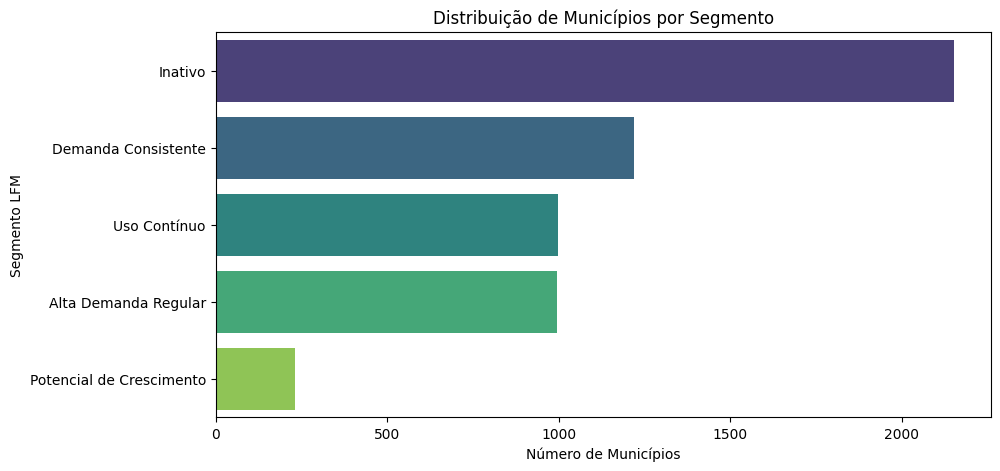

<ipython-input-13-d2c6f904bd37>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_filtrado, x="classificacao_LFM", y="Recencia", palette="viridis", ax=axes[0])
<ipython-input-13-d2c6f904bd37>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-13-d2c6f904bd37>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_filtrado, x="classificacao_LFM", y="Frequencia", palette="viridis", ax=axes[1])
<ipython-input-13-d2c6f904bd37>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

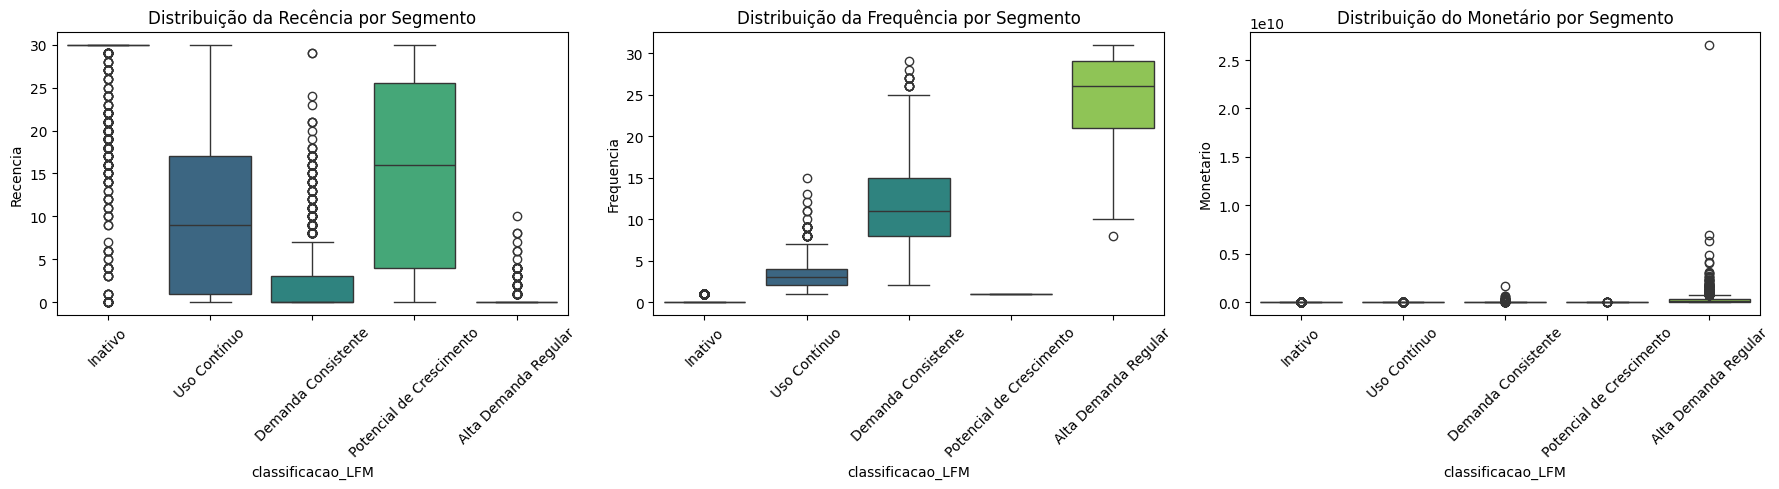

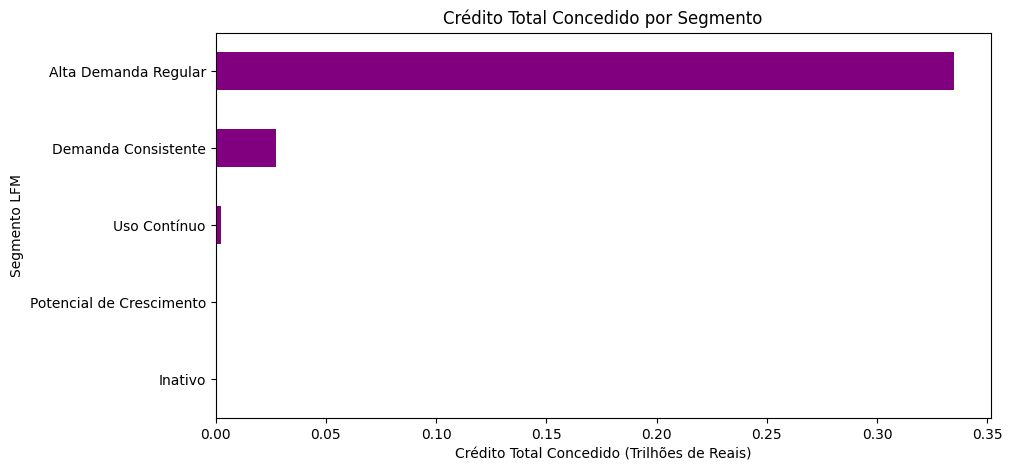

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar dados removendo "Outros Munic√≠pios" para uma an√°lise mais relevante
rfm_filtrado = rfm[rfm["classificacao_LFM"] != "Outros Munic√≠pios"]

# 1Ô∏è‚É£ Gr√°fico de Barras - Quantidade de Munic√≠pios por Segmento
plt.figure(figsize=(10, 5))
sns.countplot(
    y=rfm_filtrado["classificacao_LFM"],
    order=rfm_filtrado["classificacao_LFM"].value_counts().index,
    palette="viridis"
)
plt.xlabel("N√∫mero de Munic√≠pios")
plt.ylabel("Segmento LFM")
plt.title("Distribui√ß√£o de Munic√≠pios por Segmento")
plt.show()

# 2Ô∏è‚É£ Boxplot - Compara√ß√£o de Rec√™ncia, Frequ√™ncia e Monet√°rio por Segmento
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=rfm_filtrado, x="classificacao_LFM", y="Recencia", palette="viridis", ax=axes[0])
axes[0].set_title("Distribui√ß√£o da Rec√™ncia por Segmento")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(data=rfm_filtrado, x="classificacao_LFM", y="Frequencia", palette="viridis", ax=axes[1])
axes[1].set_title("Distribui√ß√£o da Frequ√™ncia por Segmento")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(data=rfm_filtrado, x="classificacao_LFM", y="Monetario", palette="viridis", ax=axes[2])
axes[2].set_title("Distribui√ß√£o do Monet√°rio por Segmento")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# 3Ô∏è‚É£ Cr√©dito Total Concedido por Segmento (Monet√°rio Total)
plt.figure(figsize=(10, 5))
(rfm_filtrado.groupby("classificacao_LFM")["Monetario"].sum() / 1e12).sort_values().plot(kind="barh", color="purple")
plt.xlabel("Cr√©dito Total Concedido (Trilh√µes de Reais)")
plt.ylabel("Segmento LFM")
plt.title("Cr√©dito Total Concedido por Segmento")
plt.show()


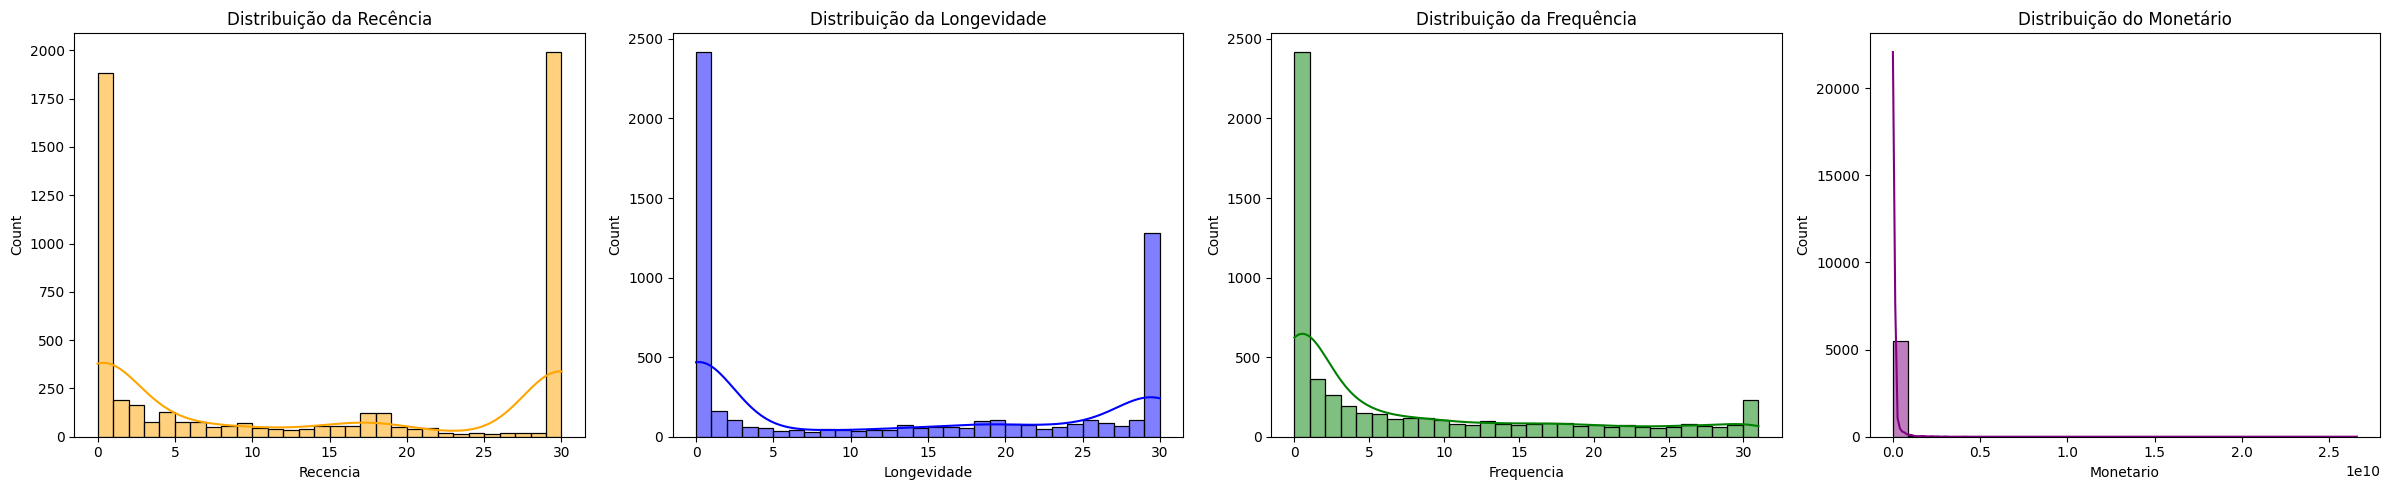

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criando subplots para Rec√™ncia, Longevidade, Frequ√™ncia e Monet√°rio no modelo LRFM
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

sns.histplot(rfm["Recencia"], bins=30, kde=True, ax=axes[0], color="orange")
axes[0].set_title("Distribui√ß√£o da Rec√™ncia")

sns.histplot(rfm["Longevidade"], bins=30, kde=True, ax=axes[1], color="blue")
axes[1].set_title("Distribui√ß√£o da Longevidade")

sns.histplot(rfm["Frequencia"], bins=30, kde=True, ax=axes[2], color="green")
axes[2].set_title("Distribui√ß√£o da Frequ√™ncia")

sns.histplot(rfm["Monetario"], bins=30, kde=True, ax=axes[3], color="purple")
axes[3].set_title("Distribui√ß√£o do Monet√°rio")

plt.tight_layout()
plt.show()


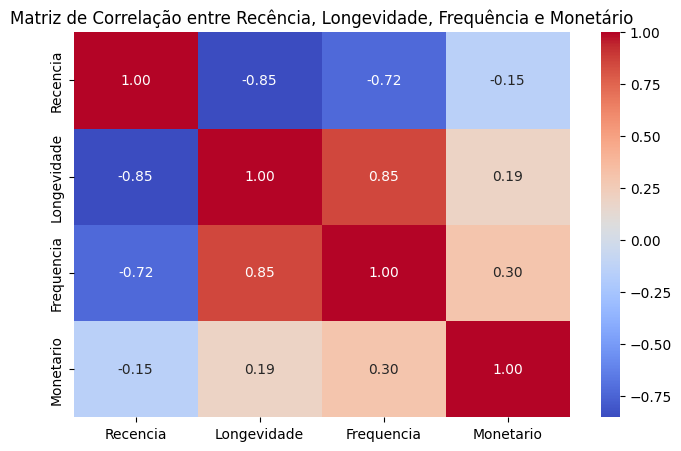

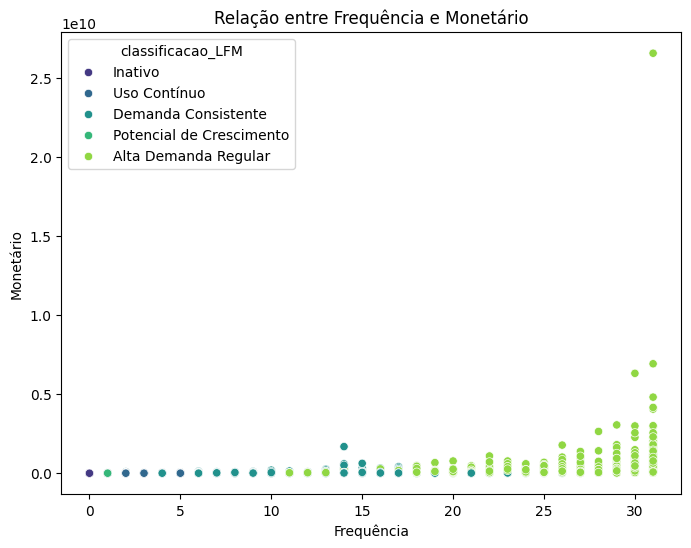

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# üî• 1Ô∏è‚É£ Matriz de Correla√ß√£o com Rec√™ncia, Longevidade, Frequ√™ncia e Monet√°rio
plt.figure(figsize=(8, 5))
sns.heatmap(
    rfm[["Recencia", "Longevidade", "Frequencia", "Monetario"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Matriz de Correla√ß√£o entre Rec√™ncia, Longevidade, Frequ√™ncia e Monet√°rio")
plt.show()

# üî• 2Ô∏è‚É£ Scatterplot entre Frequ√™ncia e Monet√°rio, agora considerando LRFM
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm, x="Frequencia", y="Monetario", hue="classificacao_LFM", palette="viridis"
)
plt.title("Rela√ß√£o entre Frequ√™ncia e Monet√°rio")
plt.xlabel("Frequ√™ncia")
plt.ylabel("Monet√°rio")
plt.show()


<ipython-input-16-4f7a42501c6b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=rfm, x="classificacao_LFM", y="Recencia", palette="viridis", ax=axes[0])
<ipython-input-16-4f7a42501c6b>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-16-4f7a42501c6b>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=rfm, x="classificacao_LFM", y="Longevidade", palette="viridis", ax=axes[1])
<ipython-input-16-4f7a42501c6b>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or

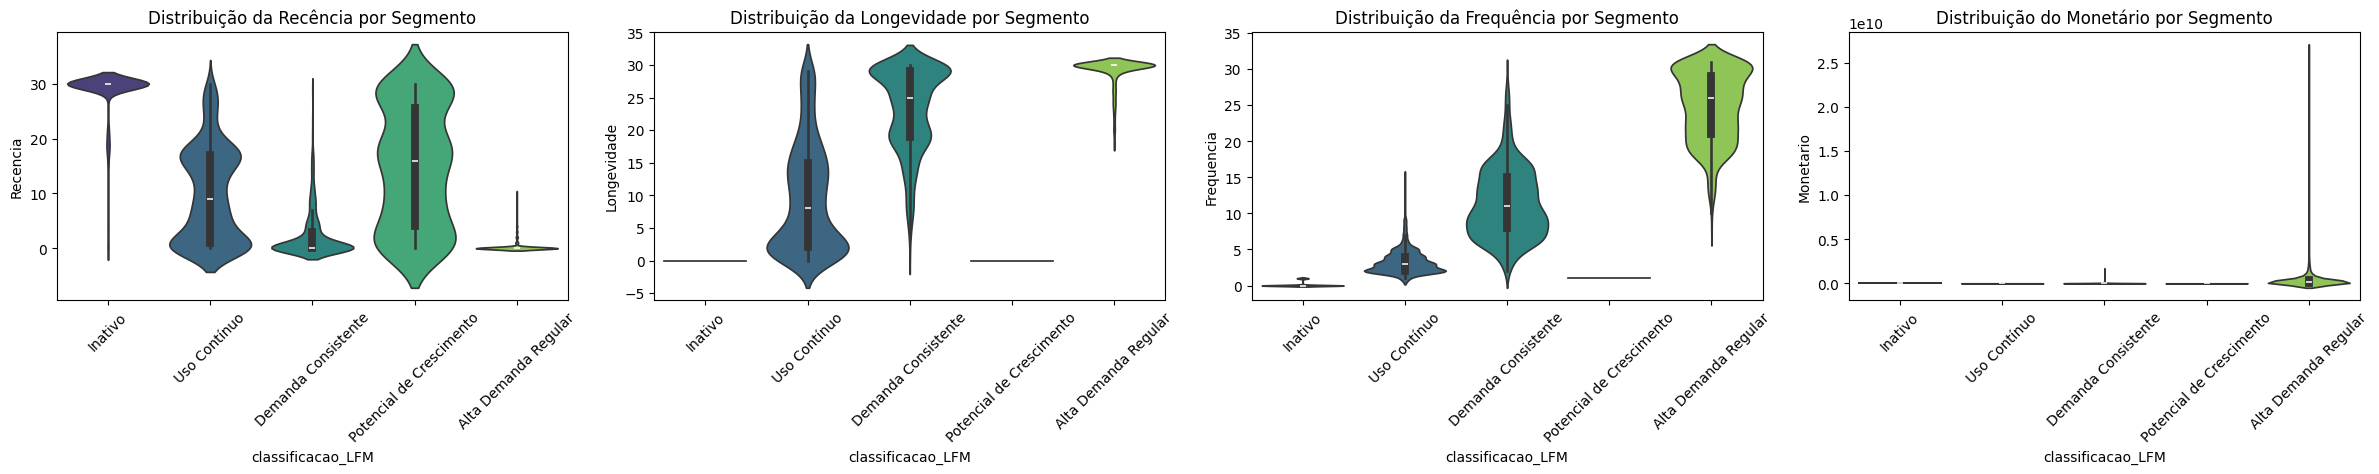

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criando subplots para visualizar a distribui√ß√£o das m√©tricas por segmento LRFM
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

sns.violinplot(data=rfm, x="classificacao_LFM", y="Recencia", palette="viridis", ax=axes[0])
axes[0].set_title("Distribui√ß√£o da Rec√™ncia por Segmento")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.violinplot(data=rfm, x="classificacao_LFM", y="Longevidade", palette="viridis", ax=axes[1])
axes[1].set_title("Distribui√ß√£o da Longevidade por Segmento")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.violinplot(data=rfm, x="classificacao_LFM", y="Frequencia", palette="viridis", ax=axes[2])
axes[2].set_title("Distribui√ß√£o da Frequ√™ncia por Segmento")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

sns.violinplot(data=rfm, x="classificacao_LFM", y="Monetario", palette="viridis", ax=axes[3])
axes[3].set_title("Distribui√ß√£o do Monet√°rio por Segmento")
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


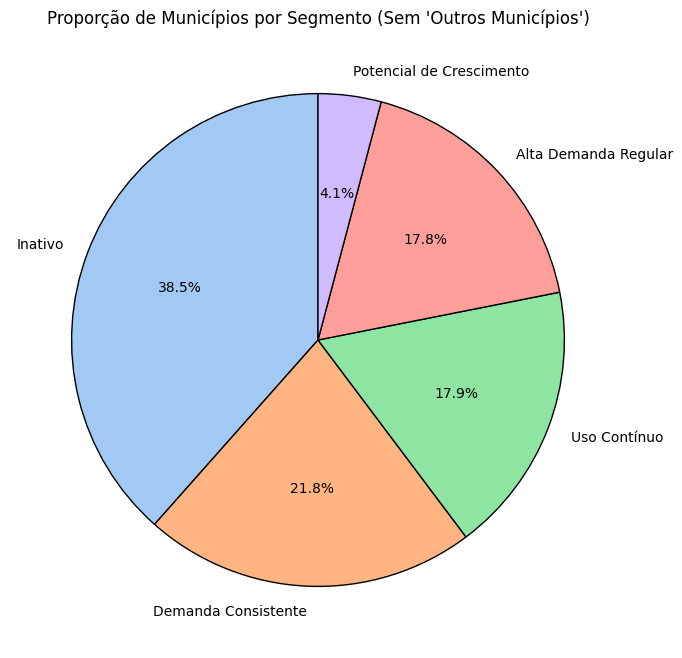

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar dados removendo "Outros Munic√≠pios" para uma an√°lise mais relevante
rfm_filtrado = rfm[rfm["classificacao_LFM"] != "Outros Munic√≠pios"]

# Contagem dos segmentos para plotagem
segment_counts = rfm_filtrado["classificacao_LFM"].value_counts()

# Criar gr√°fico de pizza
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    segment_counts,
    labels=segment_counts.index,
    autopct="%1.1f%%",
    colors=sns.color_palette("pastel"),
    startangle=90,
    wedgeprops={"edgecolor": "black"}
)

# Ajustar manualmente a posi√ß√£o do r√≥tulo e porcentagem de "Decl√≠nio de Cr√©dito"
for i, text in enumerate(texts):
    if text.get_text() == "Decl√≠nio de Cr√©dito":
        text.set_y(text.get_position()[1] + 0.05)  # Mant√©m o r√≥tulo um pouco acima
        text.set_x(text.get_position()[0] - 0.3)  # Move o r√≥tulo um pouco para a esquerda
        percent_text = autotexts[i]

        # Move a porcentagem exatamente para cima da fatia rosa
        percent_text.set_y(text.get_position()[1] - 0.09)

# T√≠tulo do gr√°fico
plt.title("Propor√ß√£o de Munic√≠pios por Segmento (Sem 'Outros Munic√≠pios')")
plt.ylabel("")  # Remove o r√≥tulo do eixo Y
plt.show()


In [18]:
from scipy.stats import f_oneway, levene
import pandas as pd

# Definir vari√°veis para an√°lise estat√≠stica no modelo LFM
variaveis = ["Recencia", "Longevidade", "Frequencia", "Monetario"]

# Criar dicion√°rios para armazenar os resultados
resultados_anova = {}
resultados_levene = {}

# Calcular ANOVA e Teste de Levene para cada vari√°vel considerando os clusters
for var in variaveis:
    grupos = [rfm[var][rfm["cluster"] == i] for i in rfm["cluster"].unique()]
    resultados_anova[var] = f_oneway(*grupos)
    resultados_levene[var] = levene(*grupos)

# Criar DataFrame com os resultados
resultados_df = pd.DataFrame({
    "ANOVA_F": [resultados_anova[var].statistic for var in variaveis],
    "ANOVA_p": [resultados_anova[var].pvalue for var in variaveis],
    "Levene_F": [resultados_levene[var].statistic for var in variaveis],
    "Levene_p": [resultados_levene[var].pvalue for var in variaveis]
}, index=variaveis)

# Ajustar a exibi√ß√£o dos valores em nota√ß√£o cient√≠fica for√ßada
pd.set_option("display.float_format", lambda x: f"{x:.5e}")  # Exibir 50 casas decimais em nota√ß√£o cient√≠fica

# Exibir resultados
print("Resultados dos Testes ANOVA e Levene (Com Precis√£o Extrema para p-value):")
print(resultados_df)


Resultados dos Testes ANOVA e Levene (Com Precis√£o Extrema para p-value):
                ANOVA_F     ANOVA_p    Levene_F     Levene_p
Recencia    2.28277e+03 0.00000e+00 9.34230e+01 3.30714e-112
Longevidade 1.31202e+04 0.00000e+00 4.18097e+02  0.00000e+00
Frequencia  1.45887e+04 0.00000e+00 3.80677e+02  0.00000e+00
Monetario   1.43516e+04 0.00000e+00 8.15284e+02  0.00000e+00


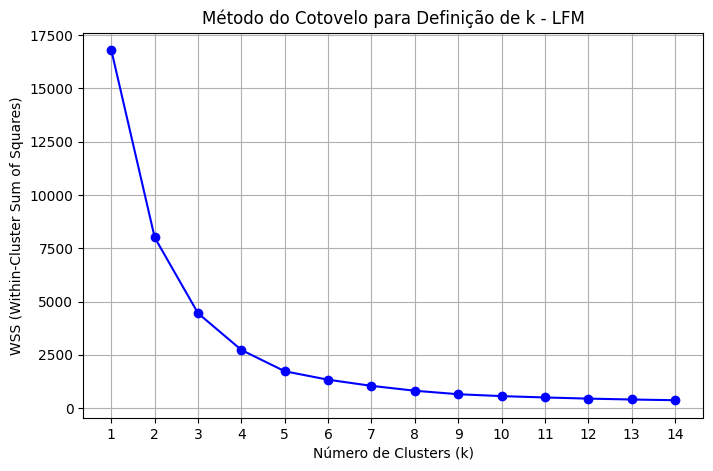

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecionar apenas as vari√°veis LFM para an√°lise
X = rfm[["Longevidade", "Frequencia", "Monetario"]]

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcular WSS para diferentes n√∫meros de clusters
wss = []
k_values = range(1, 15)  # Testar de 1 a 15 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=123)
    kmeans.fit(X_scaled)
    wss.append(kmeans.inertia_)  # Soma dos quadrados intra-clusters

# Plotar o gr√°fico do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(k_values, wss, marker='o', linestyle='-', color='b')
plt.xlabel("N√∫mero de Clusters (k)")
plt.ylabel("WSS (Within-Cluster Sum of Squares)")
plt.title("M√©todo do Cotovelo para Defini√ß√£o de k - LFM")
plt.xticks(k_values)
plt.grid()
plt.show()
